In [277]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import pearsonr, ttest_ind
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

from IPython.display import display

# **LOAD DATA**

In [278]:
df = pd.read_csv("combined_dataset.csv")

display(df.head())
print(df.info())
data_types = df.dtypes
print(data_types)

,Date,Day,Total_Screen,Ent_Screen,Study_Hrs,Tasks_Done,Tasks_Planned,Mood,Quality,Notes
0,11/11/2025,Tuesday,5.2,3.5,2.0,2,3,3,3,First day of class
1,12/11/2025,Wednesday,4.8,3.0,2.5,3,4,4,4,NaN
2,13/11/2025,Thursday,5.5,4.0,1.5,2,4,2,2,Felt tired
3,14/11/2025,Friday,6.0,4.5,1.0,1,3,2,2,NaN
4,15/11/2025,Saturday,7.2,6.0,0.5,1,2,3,3,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           63 non-null     object 
 1   Day            63 non-null     object 
 2   Total_Screen   63 non-null     float64
 3   Ent_Screen     63 non-null     float64
 4   Study_Hrs      63 non-null     float64
 5   Tasks_Done     63 non-null     int64  
 6   Tasks_Planned  63 non-null     int64  
 7   Mood           63 non-null     int64  
 8   Quality        63 non-null     int64  
 9   Notes          9 non-null      object 
dtypes: float64(3), int64(4), object(3)
memory usage: 5.1+ KB
None
Date              object
Day               object
Total_Screen     float64
Ent_Screen       float64
Study_Hrs        float64
Tasks_Done         int64
Tasks_Planned      int64
Mood               int64
Quality            int64
Notes             object
dtype: object


In [279]:
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

In [280]:
df["Notes"] = df["Notes"].fillna("")

In [281]:
print("\n📊 Missing values per column:")
print(df.isnull().sum())


📊 Missing values per column:
Date             0
Day              0
Total_Screen     0
Ent_Screen       0
Study_Hrs        0
Tasks_Done       0
Tasks_Planned    0
Mood             0
Quality          0
Notes            0
dtype: int64


# **FEATURE ENGINEERING**

In [282]:
df['Completion_Rate'] = df['Tasks_Done'] / df['Tasks_Planned'].replace(0, np.nan)
df['Efficiency'] = df['Tasks_Done'] / df['Study_Hrs'].replace(0, np.nan)
df['Ent_Ratio'] = df['Ent_Screen'] / df['Total_Screen']

print(df[["Completion_Rate","Efficiency","Ent_Ratio"]].head())

   Completion_Rate  Efficiency  Ent_Ratio
0         0.666667    1.000000   0.673077
1         0.750000    1.200000   0.625000
2         0.500000    1.333333   0.727273
3         0.333333    1.000000   0.750000
4         0.500000    2.000000   0.833333


# **DESCRIPTIVE STATS**

In [283]:
num_cols = ['Total_Screen', 'Ent_Screen', 'Study_Hrs', 'Tasks_Done',
            'Tasks_Planned', 'Mood', 'Quality', 'Completion_Rate', 'Efficiency']
stats = df[num_cols].describe().round(2)
print(stats)

       Total_Screen  Ent_Screen  Study_Hrs  Tasks_Done  Tasks_Planned   Mood  \
count         63.00       63.00      63.00       63.00          63.00  63.00   
mean           5.86        4.44       1.66        2.29           3.22   3.29   
std            1.13        1.42       1.09        1.14           0.97   0.87   
min            4.00        2.20       0.00        0.00           0.00   2.00   
25%            5.00        3.20       0.80        1.50           3.00   3.00   
50%            5.80        4.20       1.50        2.00           3.00   3.00   
75%            6.80        5.80       2.50        3.00           4.00   4.00   
max            8.00        7.00       3.80        4.00           5.00   5.00   

       Quality  Completion_Rate  Efficiency  
count    63.00            62.00       61.00  
mean      3.11             0.67        1.62  
std       0.97             0.21        0.68  
min       1.00             0.00        0.00  
25%       2.50             0.50        1.20  
50%

# **CORRELATION HEATMAP**

In [284]:
corr_cols = ['Total_Screen', 'Ent_Screen', 'Study_Hrs', 'Tasks_Done',
             'Mood', 'Quality', 'Completion_Rate', 'Efficiency']
corr = df[corr_cols].corr()


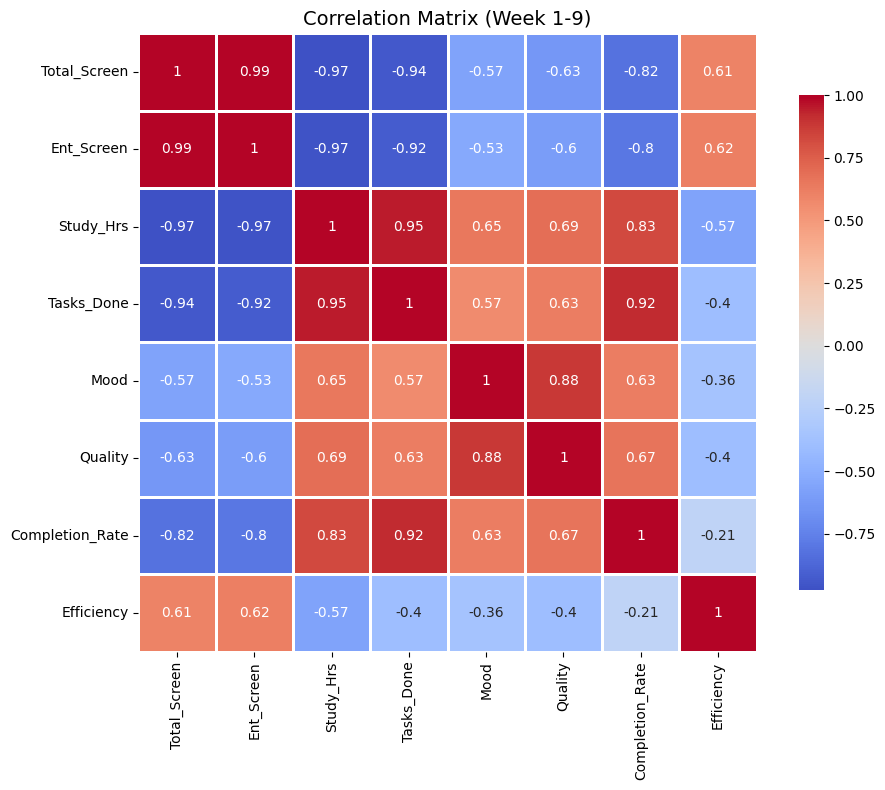

✅ Heatmap saved as 'heatmap_week1_9.png'


In [285]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix (Week 1-9)', fontsize=14)
plt.tight_layout()
plt.savefig('heatmap_week1_9.png', dpi=300)
plt.show()
print("✅ Heatmap saved as 'heatmap_week1_9.png'")

# **MULTICOLLINEARITY CHECK (VIF)**

In [286]:
vif_data = df[['Ent_Screen', 'Study_Hrs', 'Mood']].dropna()  # Total_Screen removed
vif = pd.DataFrame()
vif["Feature"] = vif_data.columns
vif["VIF"] = [variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])]
print(vif.round(2))

print("\n📌 VIF Interpretation:")
print("- VIF = 1: No correlation")
print("- 1 < VIF < 5: Moderate correlation (acceptable)")
print("- VIF > 5: High correlation (problematic)")

      Feature    VIF
0  Ent_Screen  10.15
1   Study_Hrs  12.00
2        Mood  31.70

📌 VIF Interpretation:
- VIF = 1: No correlation
- 1 < VIF < 5: Moderate correlation (acceptable)
- VIF > 5: High correlation (problematic)


# **TIME SERIES PLOTS**


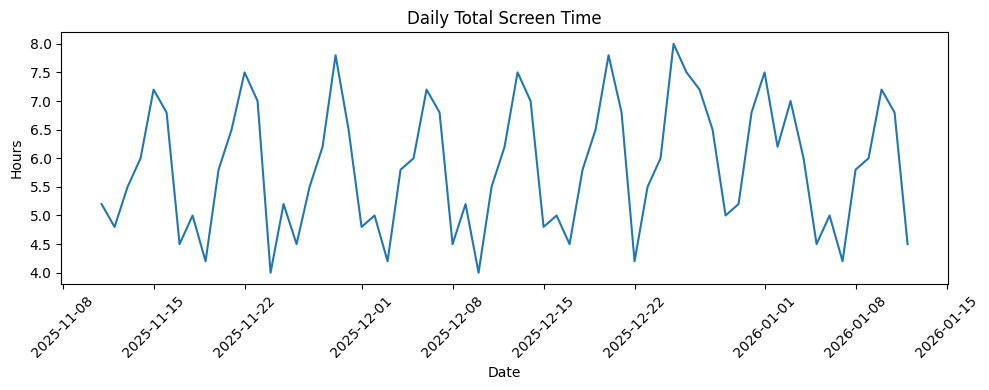

In [287]:
plt.figure(figsize=(10,4))
plt.plot(df["Date"], df["Total_Screen"])
plt.title("Daily Total Screen Time")
plt.xlabel("Date")
plt.ylabel("Hours")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("screen_trend.png")
plt.show()

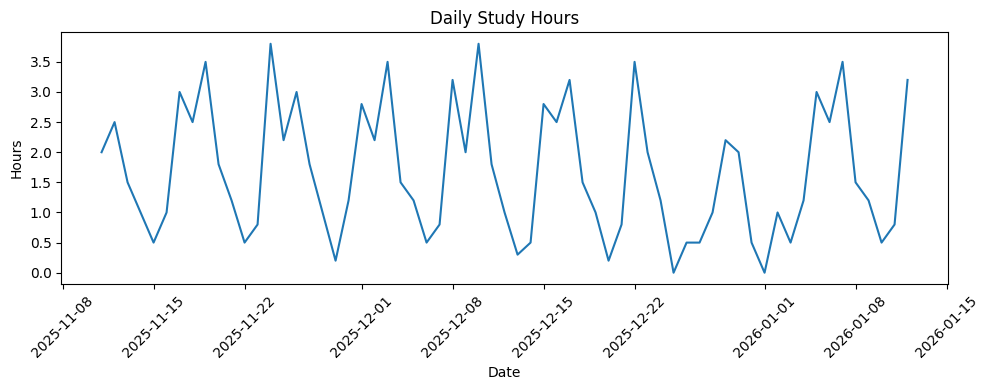

In [288]:
plt.figure(figsize=(10,4))
plt.plot(df["Date"], df["Study_Hrs"])
plt.title("Daily Study Hours")
plt.xlabel("Date")
plt.ylabel("Hours")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("study_trend.png")
plt.show()


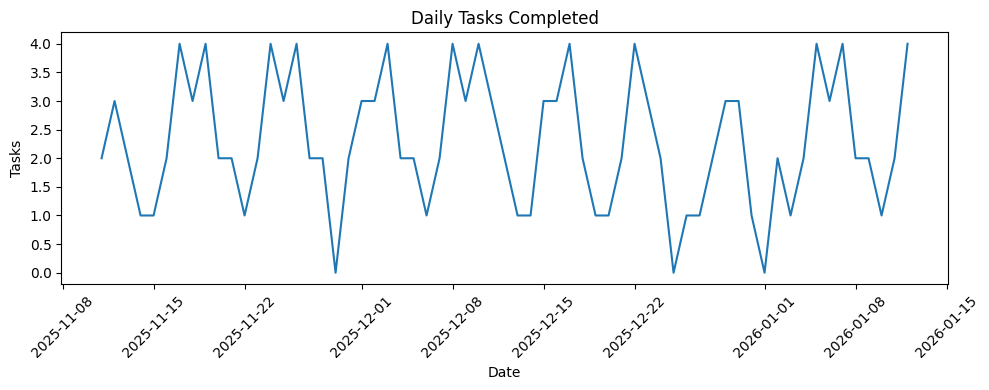

In [289]:
plt.figure(figsize=(10,4))
plt.plot(df["Date"], df["Tasks_Done"])
plt.title("Daily Tasks Completed")
plt.xlabel("Date")
plt.ylabel("Tasks")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("tasks_trend.png")
plt.show()

# **HISTOGRAMS**

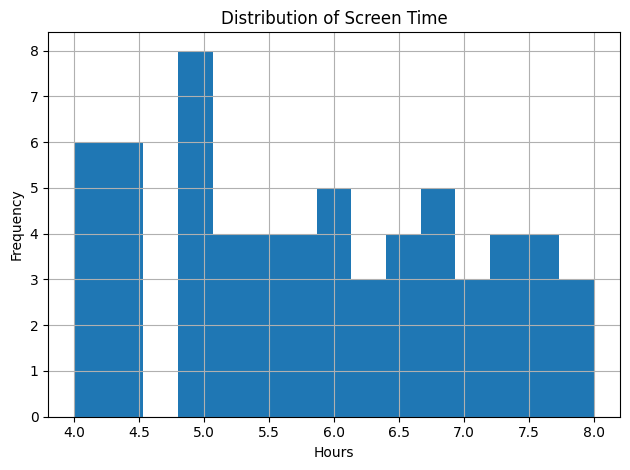

In [290]:
df["Total_Screen"].hist(bins=15)
plt.title("Distribution of Screen Time")
plt.xlabel("Hours")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("screen_hist.png")
plt.show()

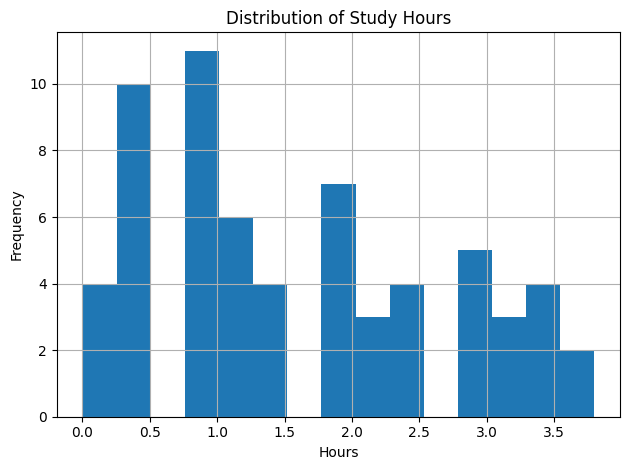

In [291]:
df["Study_Hrs"].hist(bins=15)
plt.title("Distribution of Study Hours")
plt.xlabel("Hours")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("study_hist.png")
plt.show()

# **PEARSON CORRELATION TEST**

In [292]:
r, p = pearsonr(df['Ent_Screen'].dropna(), df['Tasks_Done'].dropna())
print(f"Ent_Screen vs Tasks_Done: r = {r:.3f}, p = {p:.4f}")
if p < 0.05:
    print("Statistically significant (p < 0.05)")
else:
    print("Not statistically significant")

Ent_Screen vs Tasks_Done: r = -0.922, p = 0.0000
Statistically significant (p < 0.05)


In [293]:
r2, p2 = pearsonr(df['Ent_Screen'].dropna(), df['Study_Hrs'].dropna())
print(f"\nEnt_Screen vs Study_Hrs: r = {r2:.3f}, p = {p2:.4f}")


Ent_Screen vs Study_Hrs: r = -0.966, p = 0.0000


# **T-TEST LOW VS HIGH SCREEN**

In [294]:
low_screen = df[df['Ent_Screen'] <= 3.5]['Tasks_Done'].dropna()   # Below average
high_screen = df[df['Ent_Screen'] >= 5.5]['Tasks_Done'].dropna()  # Above average

print(f"Low screen group (≤3.5 hrs): n = {len(low_screen)}, mean = {low_screen.mean():.2f}")
print(f"High screen group (≥5.5 hrs): n = {len(high_screen)}, mean = {high_screen.mean():.2f}")

t_stat, p_val = ttest_ind(low_screen, high_screen)
print(f"\nT-statistic: {t_stat:.3f}")
print(f"P-value: {p_val:.4f}")

if p_val < 0.05:
    print("Significant difference between groups")
else:
    print("No significant difference")


Low screen group (≤3.5 hrs): n = 22, mean = 3.50
High screen group (≥5.5 hrs): n = 21, mean = 1.19

T-statistic: 11.848
P-value: 0.0000
Significant difference between groups


In [295]:
t_stat, p_val = ttest_ind(low_screen, high_screen)
print(f"\nT-statistic: {t_stat:.3f}")
print(f"P-value: {p_val:.4f}")

if p_val < 0.05:
    print("Significant difference between groups")
else:
    print("No significant difference")


T-statistic: 11.848
P-value: 0.0000
Significant difference between groups


# **LINEAR REGRESSION MODEL**

In [296]:
features = ['Ent_Screen', 'Study_Hrs', 'Mood']  # Total_Screen at Quality removed
target = 'Tasks_Done'

In [297]:
model_df = df[features + [target]].dropna()
print(f"Rows after dropping NA: {len(model_df)}")

Rows after dropping NA: 63


In [298]:
X = model_df[features]
y = model_df[target]

In [299]:
# Split into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train size: {len(X_train)} rows")
print(f"Test size: {len(X_test)} rows")

Train size: 50 rows
Test size: 13 rows


In [300]:
# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Evaluation metrics
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)

print("\n📊 MODEL PERFORMANCE:")
print(f"Train R²: {train_r2:.3f}")
print(f"Test R²:  {test_r2:.3f}")
print(f"Test RMSE: {test_rmse:.3f} tasks")
print(f"Test MAE:  {test_mae:.3f} tasks")


📊 MODEL PERFORMANCE:
Train R²: 0.928
Test R²:  0.794
Test RMSE: 0.449 tasks
Test MAE:  0.370 tasks


# **Cross-validation (5-fold)**

In [301]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
print(f"\n📊 CROSS-VALIDATION R² (5-fold):")
print(f"Mean: {cv_scores.mean():.3f} (+/- {cv_scores.std()*2:.3f})")


📊 CROSS-VALIDATION R² (5-fold):
Mean: 0.895 (+/- 0.108)


# **Coefficients**

In [302]:
print("\n📈 Regression Coefficients:")
for f, c in zip(features, model.coef_):
    print(f"  {f}: {c:.3f}")
print(f"  Intercept: {model.intercept_:.3f}")


📈 Regression Coefficients:
  Ent_Screen: -0.071
  Study_Hrs: 1.002
  Mood: -0.132
  Intercept: 1.353


# **RESIDUAL PLOT**

In [303]:
residuals = y_test - y_test_pred

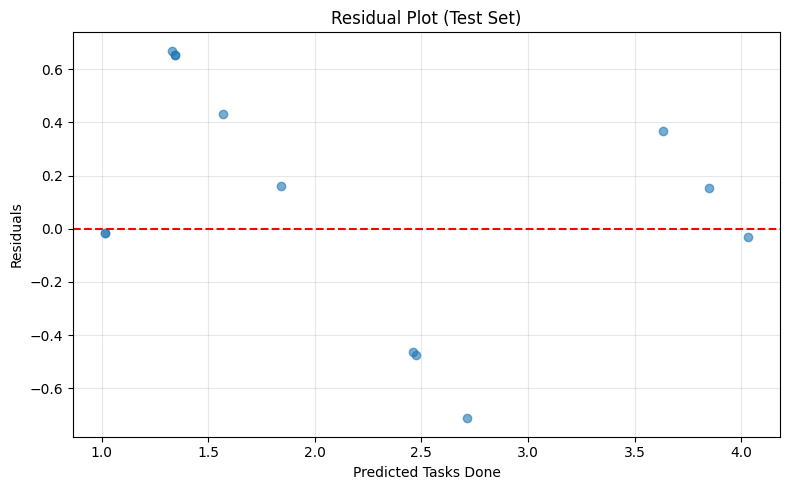

In [304]:
plt.figure(figsize=(8, 5))
plt.scatter(y_test_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Tasks Done")
plt.ylabel("Residuals")
plt.title("Residual Plot (Test Set)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('residual_plot.png', dpi=300)
plt.show()

In [305]:
print("📌 Key Findings:")
print(f"1. Screen time is strongly correlated with tasks done (r = {r:.2f})")
print(f"2. Students with high screen time (>5.5 hrs) complete significantly fewer tasks")
print(f"3. Regression model explains {test_r2*100:.1f}% of variance in test data")
print(f"4. Average prediction error: ±{test_mae:.2f} tasks")

📌 Key Findings:
1. Screen time is strongly correlated with tasks done (r = -0.92)
2. Students with high screen time (>5.5 hrs) complete significantly fewer tasks
3. Regression model explains 79.4% of variance in test data
4. Average prediction error: ±0.37 tasks
